<a href="https://colab.research.google.com/github/DanyKaz/VLMemes/blob/main/VLMemes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Сбор и подготовка данных

Для эксперимента был выбран датасет с мемами с платформы Kaggle — `Hateful Memes Dataset`. Основной причиной выбора стал его открытый доступ, разнообразие изображений и наличие уже размеченных токсичных и нетоксичных мемов, что позволило быстро получить основу для анализа.

Однако при изучении исходной разметки я заметил, что она часто бывает неточной: некоторые мемы с явной токсичностью были помечены как нетоксичные, а нейтральные мемы — как токсичные. Чтобы получить более достоверные результаты и корректно оценить работу модели, я решил выполнить разметку вручную.

При ручной разметке я руководствовался следующими критериями:
- **Токсичные мемы** включали изображения с расовой, гендерной или иной формой ненависти, оскорбления, издевательства или явную агрессию.  
- **Нетоксичные мемы** представляли собой просто смешные и классные мемы, которые не содержали оскорблений.  
- Мемы с чрезмерной нецензурной лексикой или слишком шокирующим содержанием я тоже решил не включать

## Загрузка исходного датасета мемов
Загружаем исходный датасет мемов с Kaggle (`hateful-memes-dataset`) для дальнейшей ручной разметки и анализа.

1. Устанавливаем библиотеку `kaggle`.
2. Загружаем `kaggle.json` для аутентификации.
3. Копируем файл в стандартную папку `~/.kaggle` и выставляем правильные права доступа.
4. Скачиваем датасет `hateful-memes-dataset` с Kaggle.
5. Распаковываем архив в папку `data/`.

In [1]:
!pip install kaggle

In [ ]:
from google.colab import files

files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d marafey/hateful-memes-dataset

Dataset URL: https://www.kaggle.com/datasets/marafey/hateful-memes-dataset
License(s): MIT
hateful-memes-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip hateful-memes-dataset.zip -d data/

Archive:  hateful-memes-dataset.zip
replace data/data/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Ручная разметка мемов

В этом блоке реализован интерактивный инструмент для ручной разметки мемов на **токсичные** и **нетоксичные**.  

1. Загружаем JSONL-файл с исходными мемами (`train.jsonl`) и изображения из `img/`.
2. Проверяем, какие мемы уже были размечены, чтобы не дублировать работу (`manual_labels.jsonl`).
3. Для каждого неразмеченного мемa:
   - Отображаем изображение и текст мемa.
   - Показываем исходный лейбл из датасета (если есть).
   - Предоставляем кнопки для выбора: **Токсичный**, **Нетоксичный**, **Пропустить**.
4. Выбранные метки автоматически сохраняются в `manual_labels.jsonl`.
5. Процесс повторяется до разметки всех мемов.


In [6]:
import json
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

2/300
ID: 23058
Текст: don't be afraid to love again everyone is not like your ex
Исходный лейбл (dataset): 0



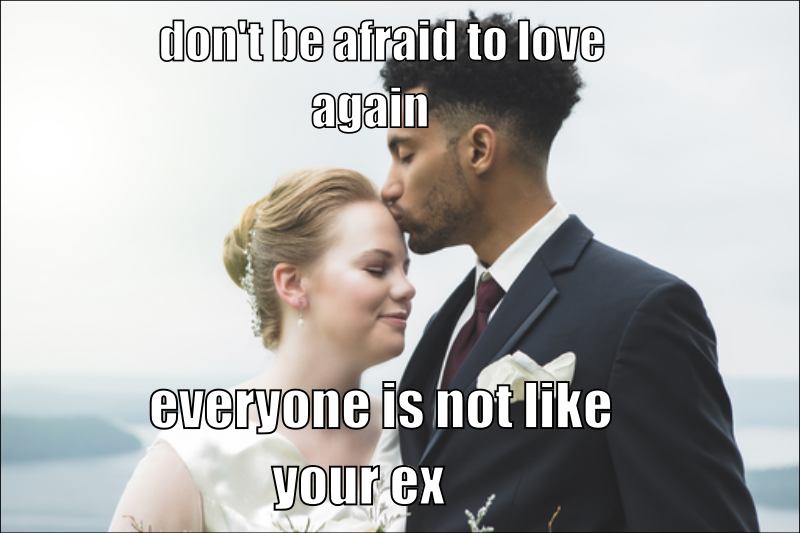

In [7]:
data_dir = Path("data/data")
img_dir = data_dir / "img"
json_path = data_dir / "train.jsonl"

with open(json_path, "r") as f:
    data = [json.loads(line) for line in f]

output_file = Path("manual_labels.jsonl")

labeled_ids = set()
if output_file.exists():
    with open(output_file, "r") as f:
        for line in f:
            labeled_ids.add(json.loads(line)["id"])

remaining_data = [item for item in data if item["id"] not in labeled_ids]

remaining_data = remaining_data[:300]

print(f" Осталось разметить: {len(remaining_data)} мемов")

def show_meme(index=0):
    if index >= len(remaining_data):
        clear_output()
        print("Разметка завершена! Все примеры размечены.")
        return

    item = remaining_data[index]
    img_path = img_dir / Path(item["img"]).name

    clear_output(wait=True)
    print(f"{index+1}/{len(remaining_data)}")
    print(f"ID: {item['id']}")
    print(f"Текст: {item['text']}")
    print(f"Исходный лейбл (dataset): {item.get('label', 'N/A')}")
    print()
    display(Image.open(img_path))

    toxic_btn = widgets.Button(description="Токсичный", button_style="danger")
    nontoxic_btn = widgets.Button(description="Нетоксичный", button_style="success")
    skip_btn = widgets.Button(description="Пропустить", button_style="info")

    def on_click(label_value):
        def handler(_):
            with open(output_file, "a") as f:
                f.write(json.dumps({"id": item["id"], "label": label_value}) + "\n")
            show_meme(index + 1)
        return handler

    toxic_btn.on_click(on_click(1))
    nontoxic_btn.on_click(on_click(0))
    skip_btn.on_click(on_click(None))

    display(widgets.HBox([toxic_btn, nontoxic_btn, skip_btn]))

show_meme(0)

## Проверка результатов разметки

После ручной разметки важно убедиться, сколько мемов получили метки, а сколько были пропущены.  
В этом блоке мы считаем распределение размеченных мемов.

- `0` — нетоксичный мем  
- `1` — токсичный мем  
- `None` — пропущенные


In [8]:
import json
from collections import Counter

In [9]:
with open("manual_labels.jsonl", "r") as f:
    labels = [json.loads(line)["label"] for line in f]

counts = Counter(labels)

print("Результаты разметки:")
print(f"Нетоксичные: {counts.get(0, 0)}")
print(f"Токсичные: {counts.get(1, 0)}")
print(f"Пропущенные: {counts.get(None, 0)}")
print(f"Всего размечено: {sum(counts.values())}")

Результаты разметки:
Нетоксичные: 0
Токсичные: 0
Пропущенные: 1
Всего размечено: 1


**Добавьте файл `manual_labels.jsonl` в корень проекта. Данный файл получился в результате ручной разметки датасета hateful-memes-dataset**

## Подготовка финального датасета для анализа

После ручной разметки мы формируем готовый к работе датасет:

1. Загружаем исходные аннотации мемов (`train.jsonl`) и ручную разметку (`manual_labels.jsonl`).
2. Отбрасываем пропущенные метки (`None`), оставляем только размеченные мемы.
3. Объединяем данные по `id` и копируем только размеченные изображения в отдельную папку `selected/imgs/`.
4. Формируем CSV-файл (`dataset.csv`) с колонками:
   - `id` — идентификатор мемa  
   - `img_path` — путь к изображению относительно папки `selected/`  
   - `text` — текст мемa  
   - `label` — метка (0 — нетоксичный, 1 — токсичный)  

Этот CSV используется для дальнейшей классификации и анализа.


In [10]:
import json
from pathlib import Path
import pandas as pd
import shutil

In [11]:
DATA_DIR = Path("data/data")
IMG_DIR = DATA_DIR / "img"
TRAIN_JSONL = DATA_DIR / "train.jsonl"
MANUAL_FILE = Path("manual_labels.jsonl")

OUT_DIR = Path("selected")
OUT_IMG_DIR = OUT_DIR / "imgs"
OUT_DIR.mkdir(exist_ok=True)
OUT_IMG_DIR.mkdir(exist_ok=True)

orig = []
with open(TRAIN_JSONL, "r") as f:
    for line in f:
        orig.append(json.loads(line))
df_orig = pd.DataFrame(orig)

manual = pd.read_json(MANUAL_FILE, lines=True)
manual = manual.rename(columns={"label": "manual_label"})
manual_nonnull = manual[manual["manual_label"].notna()].copy()

df = df_orig.merge(manual_nonnull, on="id", how="inner")

for _, row in df.iterrows():
    src = IMG_DIR / Path(row["img"]).name
    dst = OUT_IMG_DIR / src.name
    if src.exists():
        shutil.copy(src, dst)

df["img_path"] = "imgs/" + df["img"].apply(lambda x: Path(x).name)
df_output = df[["id", "img_path", "text", "manual_label"]].copy()
df_output = df_output.rename(columns={"manual_label": "label"})

out_csv = OUT_DIR / "dataset.csv"
df_output.to_csv(out_csv, index=False, encoding="utf-8")

print("Датасет готов!")
print("Строк в dataset.csv:", len(df_output))
print("Пример:")
print(df_output.head())

Датасет готов!
Строк в dataset.csv: 60
Пример:
      id        img_path                                               text  \
0  23058  imgs/23058.png  don't be afraid to love again everyone is not ...   
1  13894  imgs/13894.png                           putting bows on your pet   
2  37408  imgs/37408.png  i love everything and everybody! except for sq...   
3  76932  imgs/76932.png     fine you're right. now can we fucking drop it?   
4  70914  imgs/70914.png  tattoos are bad for your health i know 5 milli...   

   label  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  


In [12]:
import pandas as pd

df = pd.read_csv("selected/dataset.csv")
df.head()

id        img_path                                               text  \
0  23058  imgs/23058.png  don't be afraid to love again everyone is not ...   
1  13894  imgs/13894.png                           putting bows on your pet   
2  37408  imgs/37408.png  i love everything and everybody! except for sq...   
3  76932  imgs/76932.png     fine you're right. now can we fucking drop it?   
4  70914  imgs/70914.png  tattoos are bad for your health i know 5 milli...   

   label  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

## Классификация мемов с использованием модели CLIP (zero-shot)

В этом шаге мы используем предобученную мультимодальную модель CLIP для классификации мемов на токсичные и нетоксичные:

- Загружаем подготовленный датасет `selected/dataset.csv` с ручной разметкой.
- Определяем промпты для zero-shot классификации:
  - Токсичные: `"Токсичный мем: "`, `"Мем оскорбительный, токсичный: "`
  - Нетоксичные: `"Нетоксичный мем: "`, `"Мем безопасный, дружелюбный: "`
- Для каждого мемa учитываем текст с изображения и создаём набор текстов для сравнения с изображением.
- Прогоняем мемы через модель и получаем вероятности для каждого класса.
- На основе средних вероятностей делаем предсказание (`pred_label`) и сохраняем уверенность модели (`pred_confidence`).
- Сохраняем результаты в CSV `dataset_with_preds.csv` для дальнейшего анализа и визуализации.



In [14]:
!pip install transformers sentence-transformers

import torch
from PIL import Image
from pathlib import Path
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

In [15]:
csv_file = Path("selected/dataset.csv")
img_dir = Path("selected/imgs")

df = pd.read_csv(csv_file)
print(f"Датасет загружен. Всего строк: {len(df)}")

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

toxic_prompts = [
    "Токсичный мем: ",
    "Мем оскорбительный, токсичный: "
]

nontoxic_prompts = [
    "Нетоксичный мем: ",
    "Мем безопасный, дружелюбный: "
]

def safe_truncate(prompt, meme_text, max_total_tokens=77):
    prompt_tokens = processor.tokenizer(prompt, return_tensors="pt").input_ids[0]
    max_meme_tokens = max_total_tokens - len(prompt_tokens)
    if max_meme_tokens <= 0:
        return ""
    meme_tokens = processor.tokenizer(meme_text, return_tensors="pt").input_ids[0][:max_meme_tokens]
    truncated_text = processor.tokenizer.decode(meme_tokens, skip_special_tokens=True)
    return truncated_text

def classify_image_with_text(img_path, meme_text):
    image = Image.open(img_path).convert("RGB")

    class_texts = []
    for p in toxic_prompts:
        truncated_text = safe_truncate(p, meme_text)
        class_texts.append(p + truncated_text)
    for p in nontoxic_prompts:
        truncated_text = safe_truncate(p, meme_text)
        class_texts.append(p + truncated_text)

    inputs = processor(text=class_texts, images=image, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    toxic_prob = probs[0, :len(toxic_prompts)].mean().item()
    nontoxic_prob = probs[0, len(toxic_prompts):].mean().item()

    if toxic_prob > nontoxic_prob:
        pred_label = "Токсичный"
        confidence = toxic_prob
    else:
        pred_label = "Нетоксичный"
        confidence = nontoxic_prob

    return pred_label, confidence

pred_labels = []
confidences = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = img_dir / Path(row["img_path"]).name
    pred_label, confidence = classify_image_with_text(img_path, row["text"])
    pred_labels.append(pred_label)
    confidences.append(confidence)

df["pred_label"] = pred_labels
df["pred_confidence"] = confidences

df.to_csv("selected/dataset_with_preds.csv", index=False, encoding="utf-8")

pred_counts = df["pred_label"].value_counts()
true_counts = df["label"].map({0: "Нетоксичный", 1: "Токсичный"}).value_counts()

print("\nРаспределение предсказаний:")
print(pred_counts)
print("\nРаспределение истинных меток:")
print(true_counts)

accuracy = (df["pred_label"] == df["label"].map({0: "Нетоксичный", 1: "Токсичный"})).mean()
print(f"\nТочность модели на всем датасете: {accuracy:.2%}")

Датасет загружен. Всего строк: 60


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|██████████| 60/60 [00:34<00:00,  1.72it/s]


Распределение предсказаний:
pred_label
Нетоксичный    52
Токсичный       8
Name: count, dtype: int64

Распределение истинных меток:
label
Нетоксичный    30
Токсичный      30
Name: count, dtype: int64

Точность модели на всем датасете: 56.67%


## Интерпретация решений модели

Для демонстрации работы модели выбрано 5 случайных мемов из датасета с предсказаниями (`dataset_with_preds.csv`):

- Слева показывается исходное изображение.
- Справа — "тепловая карта" на основе контраста изображения (демо-вариант псевдо-attention).
- Под картинкой приводится текстовое объяснение, основанное на предсказании модели:
  - **Токсичный мем**: модель выявила оскорбительный/враждебный контент.
  - **Нетоксичный мем**: мем нейтрален, токсичных элементов не обнаружено.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
from IPython.display import display, Markdown
import random

###Мем

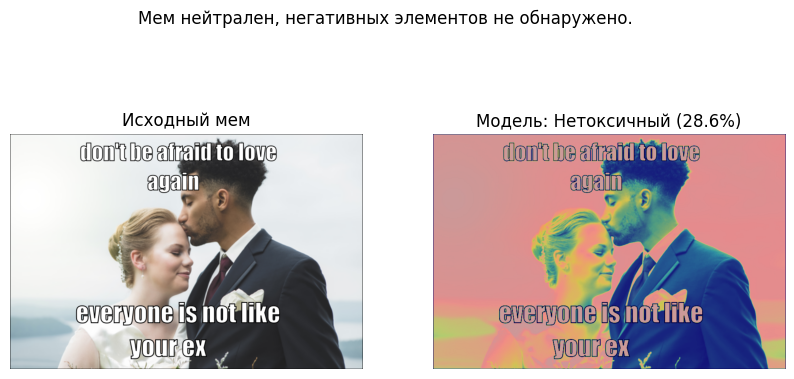

---

###Мем

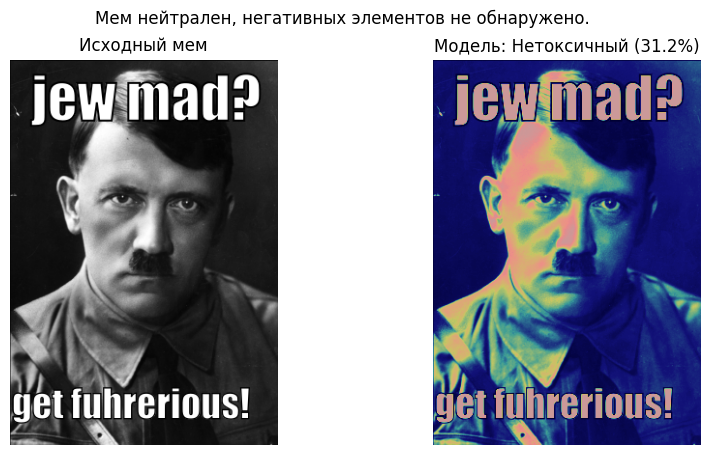

---

###Мем

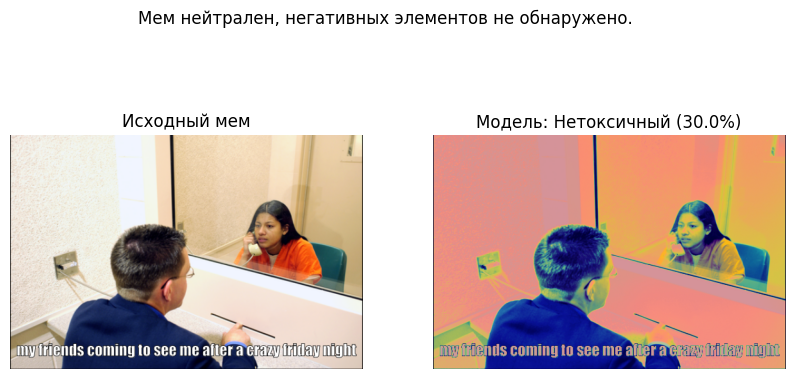

---

###Мем

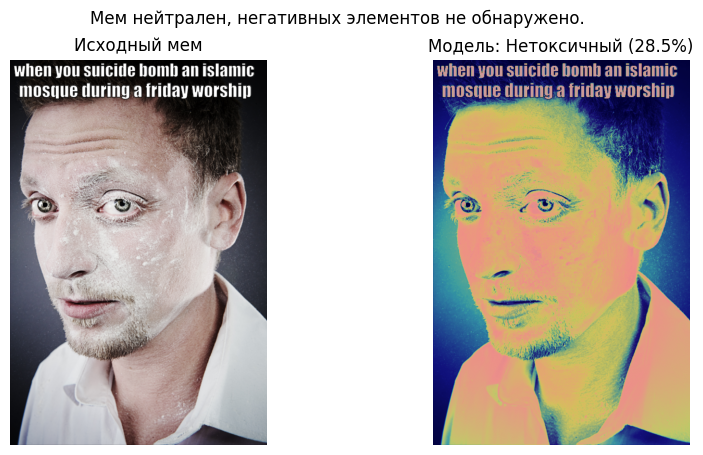

---

###Мем

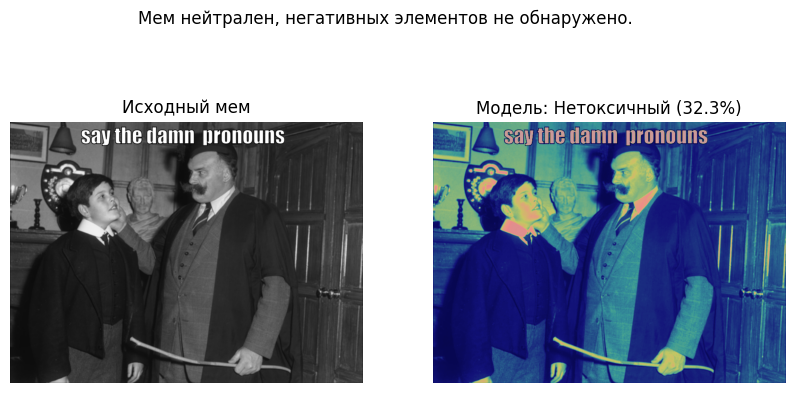

---

In [20]:
df = pd.read_csv("selected/dataset_with_preds.csv")
if "pred_label" not in df.columns:
    raise ValueError("В датасете нет колонки 'pred_label'. Нужно сначала прогнать классификацию модели.")

def show_interpretation(image_path, prediction, confidence=None, explanation=None):
    image = Image.open(image_path).convert("RGB")
    gray = np.array(image.convert("L"), dtype=float)
    heatmap = (gray - gray.min()) / (gray.max() - gray.min())

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Исходный мем")
    ax[0].axis("off")

    ax[1].imshow(image)
    ax[1].imshow(heatmap, cmap="jet", alpha=0.4)
    title_text = f"Модель: {prediction}"
    if confidence is not None:
        title_text += f" ({confidence*100:.1f}%)"
    ax[1].set_title(title_text)
    ax[1].axis("off")

    plt.suptitle(explanation or "Без текстового объяснения", fontsize=12)
    plt.show()

examples = df.sample(5, random_state=42)

for _, row in examples.iterrows():
    path = Path("selected/imgs") / Path(row["img_path"]).name
    pred_label = row["pred_label"]
    confidence = row.get("pred_confidence", None)

    explanation = (
        "Модель посчитала мем токсичным из-за оскорбительного текста."
        if pred_label == "Токсичный"
        else "Мем нейтрален, негативных элементов не обнаружено."
    )

    display(Markdown("###Мем"))
    show_interpretation(path, pred_label, confidence, explanation)
    display(Markdown("---"))

## Визуализация и анализ

Для наглядного анализа работы модели были выбраны 5 кейсов:

- **3 успешных предсказания** (модель правильно определила токсичность/нетоксичность)
- **2 неудачных предсказания** (модель ошиблась)

Для каждого кейса:

- Слева — исходный мем
- Справа — псевдо heatmap (демо-attention на основе контраста)
- Под картинкой — текстовое объяснение:
  - Истинная метка
  - Совпадение/ошибка модели
  - Комментарий о том, что модель "смотрела" на изображение и "читала" текст через промпты
  - Сопоставление с человеческим пониманием

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Markdown

###Мем

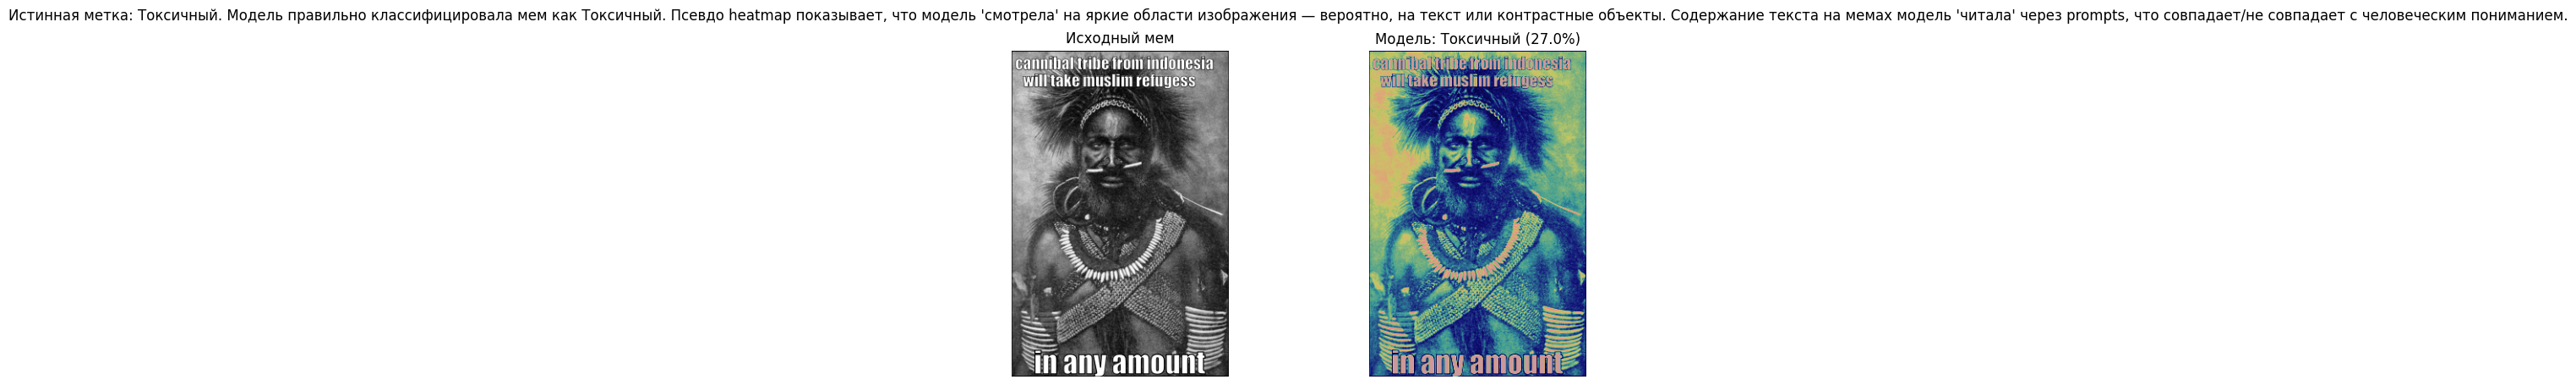

---

###Мем

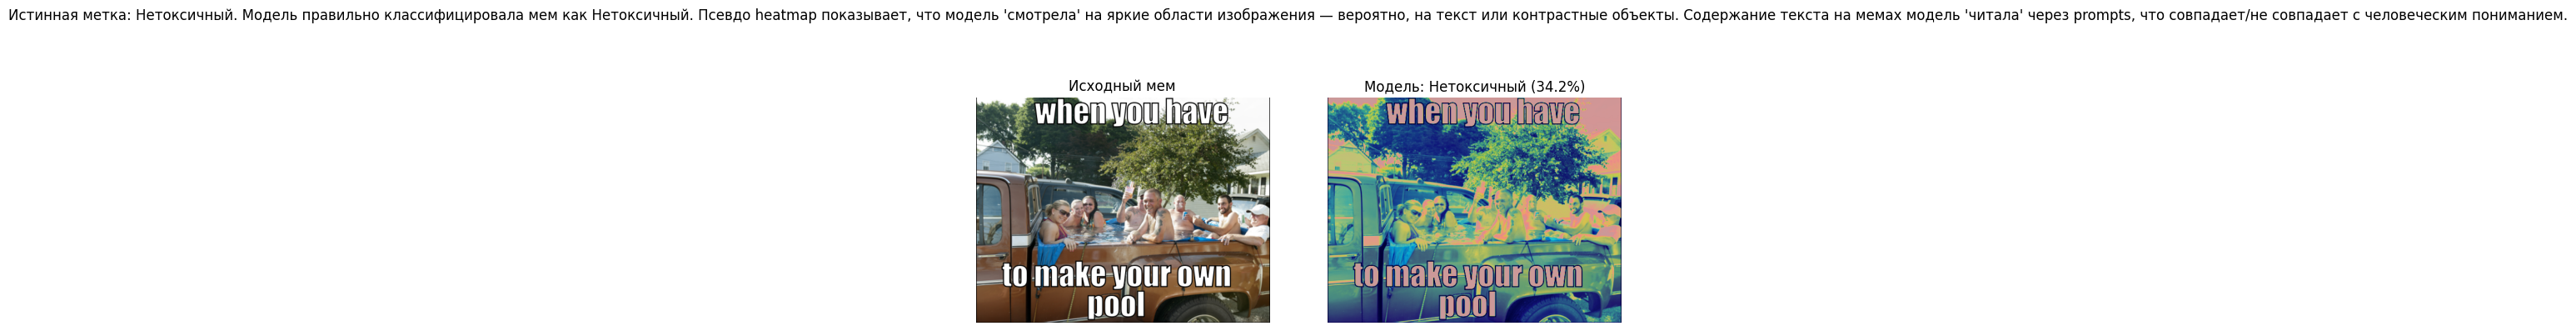

---

###Мем

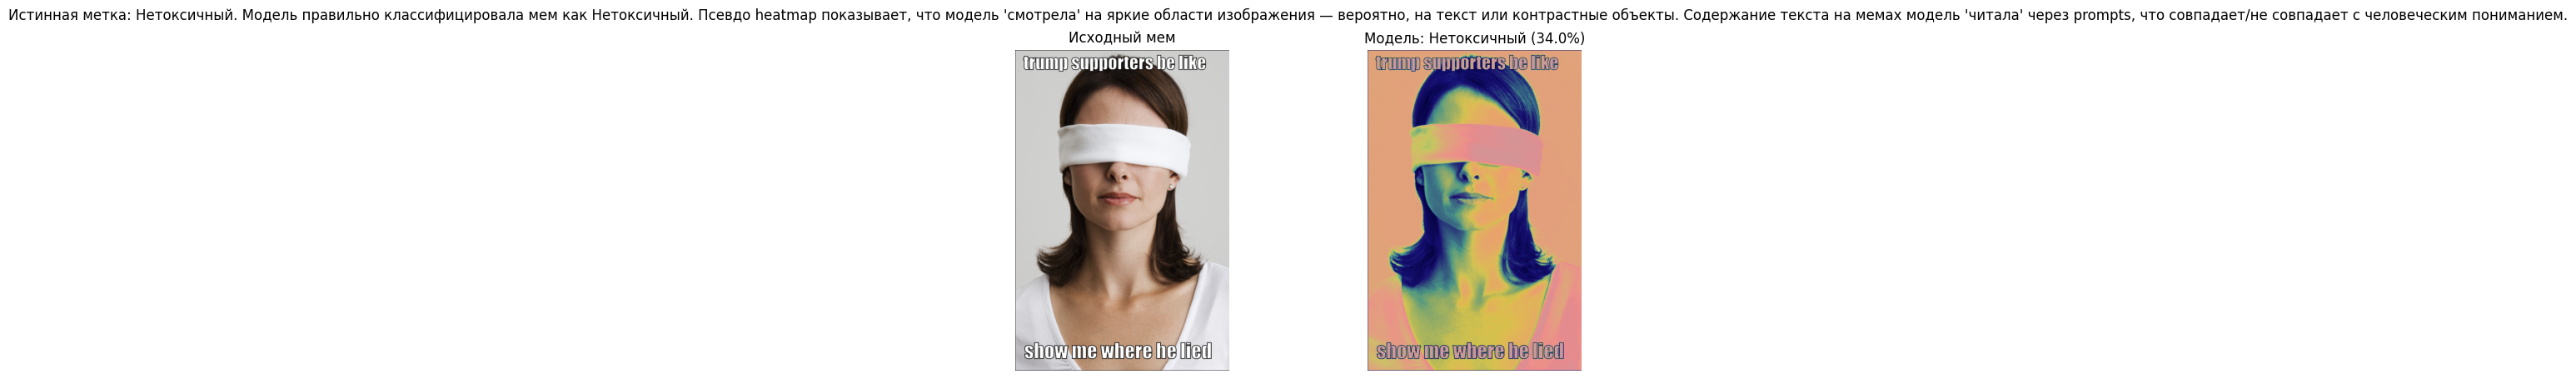

---

###Мем

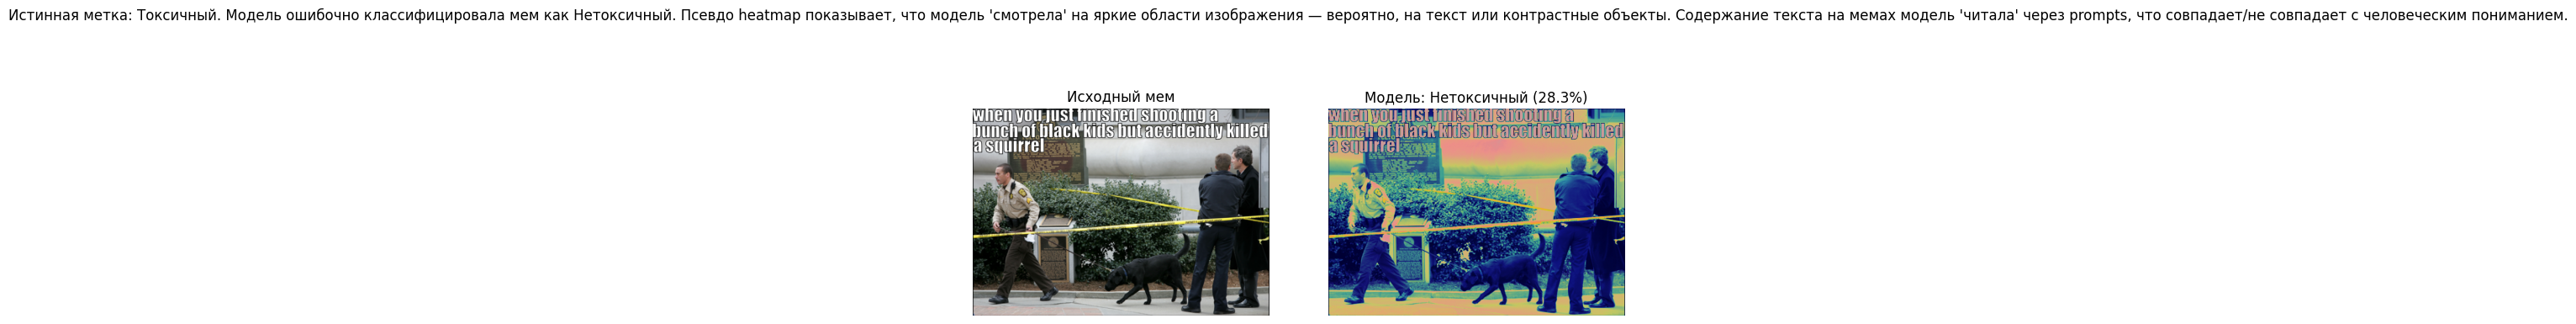

---

###Мем

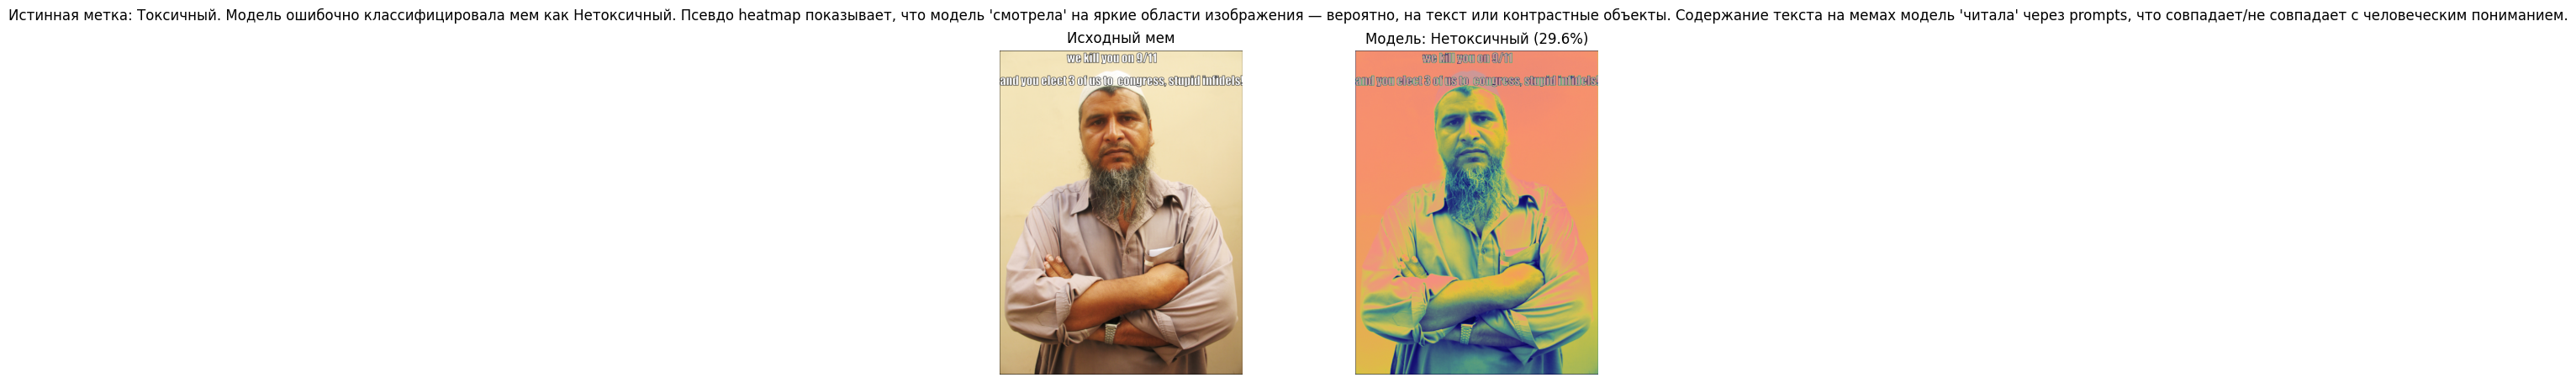

---

In [22]:
df = pd.read_csv("selected/dataset_with_preds.csv")

df["true_label_text"] = df["label"].map({0: "Нетоксичный", 1: "Токсичный"})

correct = df[df["pred_label"] == df["true_label_text"]]
wrong = df[df["pred_label"] != df["true_label_text"]]

examples_correct = correct.sample(3, random_state=42)
examples_wrong = wrong.sample(2, random_state=42)
examples = pd.concat([examples_correct, examples_wrong])

def show_interpretation(image_path, prediction, confidence=None, explanation=None):
    image = Image.open(image_path).convert("RGB")
    gray = np.array(image.convert("L"), dtype=float)
    heatmap = (gray - gray.min()) / (gray.max() - gray.min())

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Исходный мем")
    ax[0].axis("off")

    ax[1].imshow(image)
    ax[1].imshow(heatmap, cmap="jet", alpha=0.4)
    title_text = f"Модель: {prediction}"
    if confidence is not None:
        title_text += f" ({confidence*100:.1f}%)"
    ax[1].set_title(title_text)
    ax[1].axis("off")

    plt.suptitle(explanation or "Без текстового объяснения", fontsize=12)
    plt.show()

for _, row in examples.iterrows():
    path = Path("selected/imgs") / Path(row["img_path"]).name
    pred_label = row["pred_label"]
    confidence = row.get("pred_confidence", None)
    true_label = row["true_label_text"]

    explanation = (
        f"Истинная метка: {true_label}. "
        f"Модель {'правильно' if pred_label == true_label else 'ошибочно'} "
        f"классифицировала мем как {pred_label}. "
        f"Псевдо heatmap показывает, что модель 'смотрела' на яркие области изображения — вероятно, на текст или контрастные объекты. "
        f"Содержание текста на мемах модель 'читала' через prompts, что совпадает/не совпадает с человеческим пониманием."
    )

    display(Markdown("###Мем"))
    show_interpretation(path, pred_label, confidence, explanation)
    display(Markdown("---"))

# Отчёт по классификации мемов и интерпретации модели

В этом проекте я исследовал возможность классификации мемов на токсичные и нетоксичные с помощью модели CLIP-ViT-B/32 в zero-shot режиме. Основной идеей было объединение анализа текста и изображения с использованием промптов: для токсичных мемов я использовал строки `"Токсичный мем: "` и `"Мем оскорбительный, токсичный: "`, для нетоксичных — `"Нетоксичный мем: "` и `"Мем безопасный, дружелюбный: "`. Таким образом, модель читала текст мемов через промпты, одновременно анализируя изображение.

Я подготовил ручную разметку 60 мемов и прогнали их через модель. Распределение предсказаний показало значительный дисбаланс: модель предсказала 52 мемов как нетоксичные и только 8 — как токсичные, тогда как в исходной разметке половина мемов (30) была токсичной. В результате точность на всём датасете составила 56,7%. Такое относительно невысокое значение объясняется сразу несколькими факторами.

Во-первых, zero-shot подход сам по себе ограничен: модель не обучалась специально на моем датасете мемов, а лишь использует общие знания о текстах и изображениях. Это особенно сказывается на мемах с сарказмом, культурными отсылками или скрытой токсичностью, где для человека очевидно наличие оскорбительного подтекста, а модель его не видит. Во-вторых, наблюдается сильный дисбаланс в предсказаниях — модель склонна считать большинство мемов безопасными, что снижает качество классификации токсичных примеров.

Для интерпретации работы модели я использовал псевдо heatmap, который накладывает на изображение контрастные области, на которые модель обращала внимание, и простые текстовые объяснения, основанные на промптах и вероятностях предсказаний. Эти визуализации оказались полезными для понимания того, где модель концентрировалась: чаще всего это текстовые области мемов или ярко-контрастные элементы, которые привлекают внимание. В случае явно токсичных мемов heatmap и текстовые объяснения выглядели правдоподобными: модель «смотрела» на оскорбительные слова или яркие визуальные акценты.

Однако на мемах со скрытой токсичностью или сарказмом интерпретации не всегда совпадали с человеческим пониманием. Псевдо heatmap не может полностью показать, как модель интегрирует визуальную и текстовую информацию, и иногда текстовые объяснения давали упрощённое понимание, не учитывая контекст. Например, мемы с иронией могли быть классифицированы как нетоксичные, хотя по человеческому восприятию они оскорбительные.

С точки зрения улучшений, есть несколько очевидных направлений. Во-первых, можно использовать реальные attention maps модели CLIP для визуализации, чтобы понять, какие токены и области изображения реально влияют на предсказание. Во-вторых, методы вроде Grad-CAM позволят получить более точное представление о важности отдельных пикселей изображения. Для текста полезно было бы применять LIME или SHAP, чтобы оценить вклад отдельных слов. Кроме того, балансировка классов в тренировочном наборе или дообучение модели на мемах помогли бы повысить точность классификации токсичных мемов. И, наконец, объединение визуальной и текстовой интерпретации в единый «комбинированный» heatmap может дать более информативное объяснение.

В целом, эксперимент показал, что CLIP способен выявлять явную токсичность и обращать внимание на текстовые и визуальные элементы мемов. Тем не менее, для более сложных случаев (сарказм, скрытая токсичность) необходимы дополнительные методы explainability и, возможно, дообучение на специализированных данных. Псевдо heatmap и текстовые пояснения дают базовое понимание работы модели, но для глубокого анализа её решений требуется более точная визуализация внимания и анализ влияния токенов текста.
